In [17]:
import numpy as np
import struct
import matplotlib.pyplot as plt
from scipy import signal

In [31]:
filename = '/home/ricardo/Documents/Data/sdr/test_CS16_2M.iq'
filename = '/home/ricardo/Documents/Data/sdr/NOAA_9_20190928_030101_136700000Hz.CS16'
fs = 250000
fc = 137700000

In [40]:
dtype = np.dtype([('i',np.int16),('q',np.int16)])
data = np.fromfile(filename, dtype=dtype, count=-1)
cdata = data['i'] + 1j *data['q']
cdata = cdata / np.max(np.abs(cdata))
#mdata = np.sqrt(data['i']** + data['q']**2)

In [41]:
def normalize_complex_arr(a):
    a_oo = a - a.real.min() - 1j*a.imag.min() # origin offsetted
    return a_oo/np.abs(a_oo).max()

In [42]:
#cdata = normalize_complex_arr(cdata)
#cdata = cdata[750*fs:]

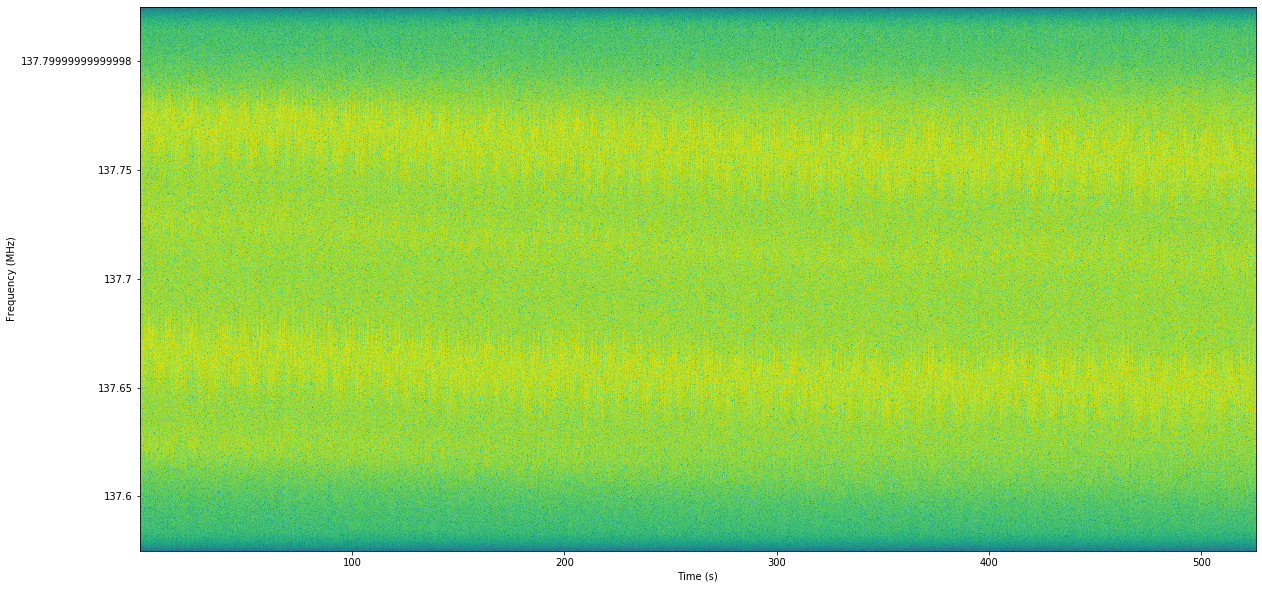

In [43]:
# Plot the spectogram of this data
fig, (ax1) = plt.subplots(nrows=1, figsize=(20,10))
Pxx, freqs, bins, im = ax1.specgram(cdata, NFFT=4096, Fs=fs, Fc=fc,noverlap = 2048 )
plt.xlabel("Time (s)")
plt.ylabel("Frequency (MHz)")

yticks = plt.yticks()
ax1.set_yticklabels((f"{np.round(x,2)*1e-6}" for x in yticks[0]))
plt.show() 



In [ ]:
# To mix the data down, generate a complex exponential 
# with phase -f_shift/Fs
f_target = 102.3e6
f_shift = f_target - fc
f_shifter = np.exp(-1.0j*2.0*np.pi* f_shift/fs*np.arange(len(cdata)))
# Try plotting this complex exponential with a scatter plot of the complex plan - 
# what do you expect it to look like?
y = cdata * f_shifter

# Plot the spectogram of this data
fig, (ax1) = plt.subplots(nrows=1, figsize=(10,10))
Pxx, freqs, bins, im = ax1.specgram(y, NFFT=1024, Fs=fs)
plt.xlabel("Time")
plt.ylabel("Frequency")

yticks = plt.yticks()
ax1.set_yticklabels((f"{x*1e-6}MHz" for x in yticks[0]))

plt.show() 


In [ ]:
f_bw = 50000
n_taps = 64 
lpf = signal.remez(n_taps, [0, f_bw, f_bw+(fs/2-f_bw)/4, fs/2], [1,0], Hz=fs)

w, h = signal.freqz(lpf)
plt.figure(figsize=(10,10))
plt.plot(w, 20 * np.log10(abs(h)))
plt.xscale('log')
plt.title('Filter frequency response')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.show()

In [ ]:
f_y = signal.lfilter(lpf, 1.0, y)
# Plot the spectogram of this data
fig, (ax1) = plt.subplots(nrows=1, figsize=(10,10))
Pxx, freqs, bins, im = ax1.specgram(f_y, NFFT=1024, Fs=fs)
plt.xlabel("Time")
plt.ylabel("Frequency")

yticks = plt.yticks()
ax1.set_yticklabels((f"{x*1e-6}MHz" for x in yticks[0]))

plt.show() 


In [ ]:
target_fs = 44100
dec_rate = int(fs / target_fs)
z = signal.decimate(f_y, dec_rate)
fs_z = fs/dec_rate

In [ ]:

# Plot the spectogram of these data
fig, (ax1) = plt.subplots(nrows=1, figsize=(20,10))
Pxx, freqs, bins, im = ax1.specgram(z, NFFT=4096, Fs=fs_z, noverlap = 2048)
plt.xlabel("Time")
plt.ylabel("Frequency")

yticks = plt.yticks()
ax1.set_yticklabels((f"{x*1e-3}kHz" for x in yticks[0]))

plt.show() 


In [ ]:

zz = np.angle(z[1:] * np.conj(z[:-1]))

In [ ]:
# Plot the spectogram of these data
fig, (ax1) = plt.subplots(nrows=1, figsize=(20,10))
Pxx, freqs, bins, im = ax1.specgram(zz, NFFT=4096, Fs=fs_z, noverlap = 2048)
plt.xlabel("Time")
plt.ylabel("Frequency")

yticks = plt.yticks()
ax1.set_yticklabels((f"{x*1e-3}kHz" for x in yticks[0]))

plt.show() 


In [ ]:
zz *= 10000 / np.max(np.abs(zz))               # scale so it's audible
zz.astype("int16").tofile("wbfm-mono.raw")    

In [ ]:
print(int(fs_z))